In [267]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import graphgp as gp
import graphgp_cuda as gp_cuda

import matplotlib.pyplot as plt
import time
from tqdm import tqdm

rng = jr.key(127)

In [268]:
rng, k1 = jr.split(rng)

points = jr.normal(k1, (100000, 2))
graph = gp.build_graph(points, n0=100, k=4, cuda=True)
points = points[graph.indices]
graph.indices = None

covariance = gp.prepare_matern_covariance_discrete(p=0, cutoff=100, r_min=1e-5, r_max=10, n_bins=1000)

In [40]:
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(xi)
var = jnp.diag(J @ J.T)

true_J = jax.jacfwd(Partial(gp.generate_dense, points, covariance))(xi)
true_var = jnp.diag(true_J @ true_J.T)

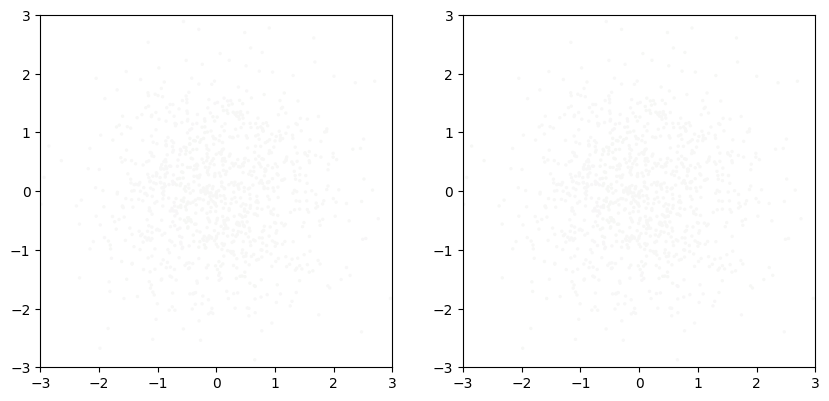

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].scatter(*points.T, c=true_var, cmap='PiYG', s=2, vmin=0.95, vmax=1.05)
axes[1].scatter(*points.T, c=var, cmap='PiYG', s=2, vmin=0.95, vmax=1.05)

for ax in axes:
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.show()

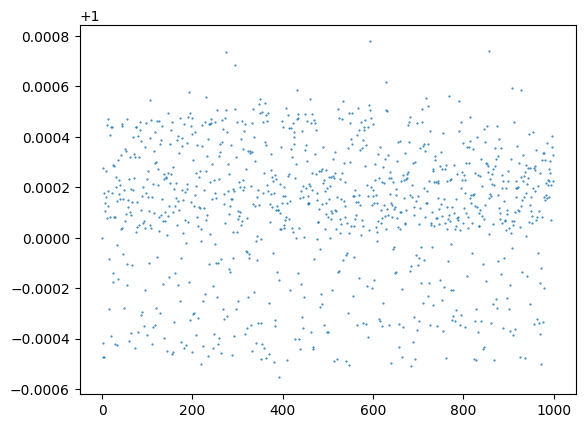

In [42]:
plt.plot(var, '.', ms=1)

In [59]:
true_values = gp.generate_dense(points, covariance, xi)
values = gp.generate_jit(graph, covariance, xi, cuda=True)

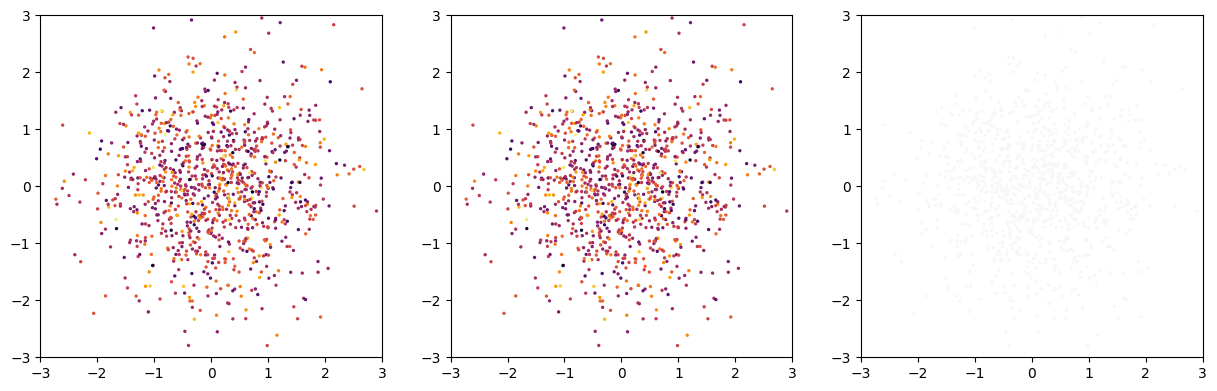

In [60]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].scatter(*points.T, c=true_values, cmap='inferno', s=2)
axes[1].scatter(*points.T, c=values, cmap='inferno', s=2)
axes[2].scatter(*points.T, c=true_values-values, cmap='PiYG', s=2, vmin=-0.1, vmax=0.1)

for ax in axes:
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.show()

# Inspect graph

In [440]:
rng, k1 = jr.split(rng)

In [441]:
points = jr.normal(k1, (1000, 2))
graph = gp.build_graph(points, n0=100, k=4, cuda=True)
points = points[graph.indices]
graph.indices = None
covariance = gp.prepare_matern_covariance_discrete(p=1, r_min=1e-4, r_max=10, n_bins=1000)

In [457]:
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(jnp.zeros((points.shape[0],)))
cov = J @ J.T
var = jnp.diag(cov)

In [458]:
jnp.flatnonzero(var < 0.95)

Array([160, 240, 270, 278, 353, 367, 373, 397, 420, 441, 488, 505, 506,
       529, 559, 588, 629, 672, 723, 735, 737, 748, 750, 781, 787, 805,
       825, 843, 864, 885, 892, 894, 905, 920, 922, 937, 955, 958, 969],      dtype=int32)

In [473]:
idx = 160
var[idx]

Array(0.9323704, dtype=float32)

In [474]:
graph.neighbors[idx - 100]

Array([ 63, 121, 130,  95], dtype=int32)

In [477]:
graph.neighbors[121-100]

Array([63, 31, 95, 15], dtype=int32)

[None]

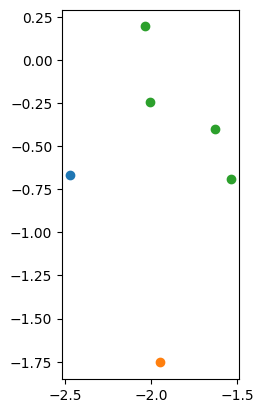

In [483]:
for i in [130, 63, graph.neighbors[130-100]]:
    plt.scatter(*points[i].T)
plt.gca().set(aspect='equal')

In [481]:
cov[graph.neighbors[idx - 100], :][:, graph.neighbors[idx - 100]]

Array([[1.000182  , 0.95421606, 0.24373233, 0.5978451 ],
       [0.95421606, 1.0003774 , 0.20177533, 0.4876039 ],
       [0.24373233, 0.20177533, 0.9996263 , 0.4396452 ],
       [0.5978451 , 0.4876039 , 0.4396452 , 1.0000598 ]], dtype=float32)

In [482]:
gp.covariance.compute_cov_matrix(covariance, points[graph.neighbors[idx - 100]], points[graph.neighbors[idx - 100]])

Array([[1.00001   , 0.95396364, 0.38280845, 0.5978137 ],
       [0.95396364, 1.00001   , 0.32336026, 0.4875949 ],
       [0.38280845, 0.32336026, 1.00001   , 0.47791776],
       [0.5978137 , 0.4875949 , 0.47791776, 1.00001   ]], dtype=float32)

# Repeated conditioning case

In [140]:
points = jnp.linspace(0, 1, 1000)[:, None]
points = jnp.concatenate([points[:1], points[1:][::-1]])
neighbors = jnp.stack([jnp.zeros(len(points)-2, dtype=int), jnp.arange(1, len(points)-1)], axis=1)
offsets = tuple(range(2, len(points) + 1))
graph = gp.Graph(points=points, neighbors=neighbors, offsets=offsets)
covariance = gp.prepare_matern_covariance_discrete(p=1, r_min=1e-4, r_max=10, n_bins=1000)

In [141]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, (points.shape[0],))
values = gp.generate_jit(graph, covariance, xi, cuda=True)

In [142]:
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(xi)
var = jnp.diag(J @ J.T)

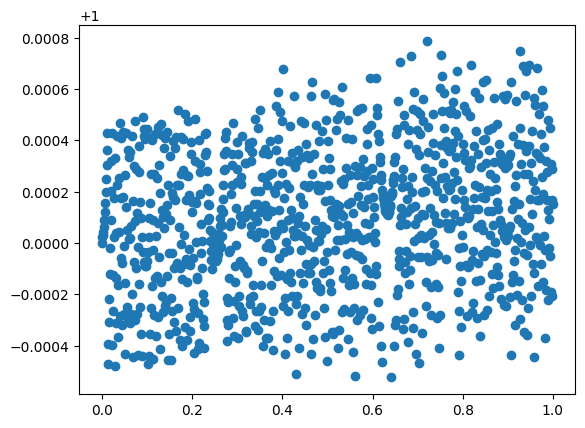

In [107]:
plt.scatter(points, var)

# Unit Circle Case

In [345]:
n_points = 300
theta = jnp.linspace(0, 2*jnp.pi, n_points, endpoint=False)
points = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)
neighbors = jnp.stack([jnp.concatenate([jnp.arange(n_points-3), jnp.array([n_points-2])]), 
                       jnp.concatenate([jnp.arange(1, n_points-2), jnp.array([0])])], axis=1)
offsets = tuple(range(2, len(points) + 1))
graph = gp.Graph(points=points, neighbors=neighbors, offsets=offsets)
covariance = gp.prepare_matern_covariance_discrete(p=1, r_min=1e-4, r_max=10, n_bins=1000)

In [346]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, (points.shape[0],))
values = gp.generate_jit(graph, covariance, xi, cuda=True)

[None]

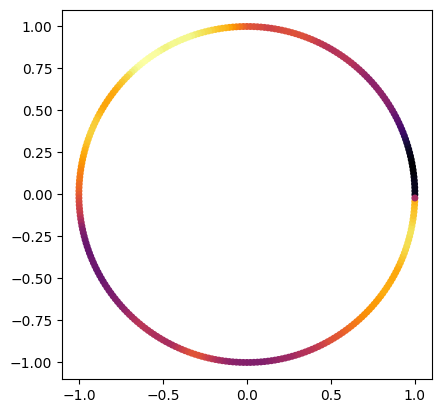

In [347]:
plt.scatter(*points.T, c=values, cmap='inferno', s=16)
plt.gca().set(aspect='equal')

In [348]:
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(xi)
var = jnp.diag(J @ J.T)

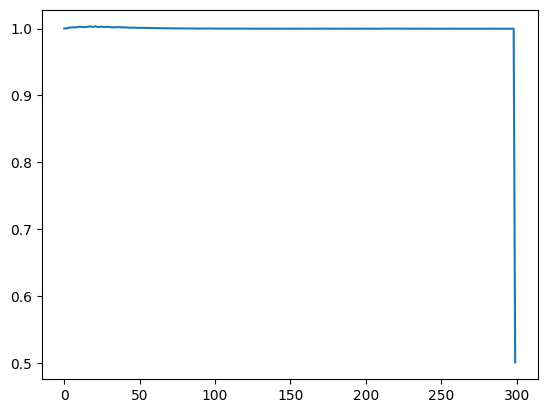

In [350]:
plt.plot(var)

In [254]:
points = jnp.array([[0.0, 0.0], [1.0, 0.0], [2.0, 0.0]])
neighbors = jnp.array([[0],[1]])
offsets = (1, 2, 3)
graph = gp.Graph(points=points, neighbors=neighbors, offsets=offsets)
covariance = gp.prepare_matern_covariance_discrete(p=1, cutoff=1, r_min=1e-4, r_max=10, n_bins=1000)

In [255]:
J = jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True))(jnp.zeros(len(points)))
cov = J @ J.T

In [256]:
cov

Array([[1.00001   , 0.4833636 , 0.23363805],
       [0.4833636 , 1.0000099 , 0.48336357],
       [0.23363805, 0.48336357, 1.0000099 ]], dtype=float32)

In [257]:
gp.covariance.compute_cov_matrix(covariance, points, points)

Array([[1.00001   , 0.48335734, 0.13973123],
       [0.48335734, 1.00001   , 0.48335734],
       [0.13973123, 0.48335734, 1.00001   ]], dtype=float32)

# Illustrate impact of cutoff

In [286]:
rng, k1 = jr.split(rng)

points = jr.normal(k1, (1000, 2))
graph = gp.build_graph(points, n0=100, k=4, cuda=True)
points = points[graph.indices]
graph.indices = None

In [287]:
covariance[1](1.0)

Array(0.99004984, dtype=float32)

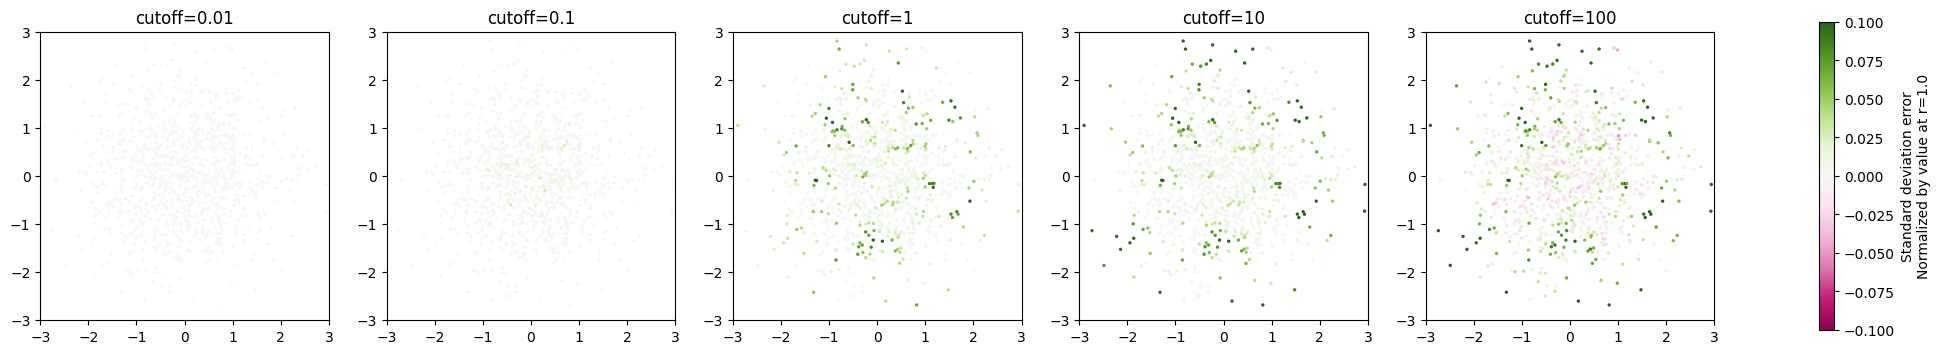

In [292]:
cutoffs = [0.01, 0.1, 1, 10, 100]
fig, axes = plt.subplots(ncols=5, figsize=(27,4))

for i, cutoff in enumerate(cutoffs):
    covariance = gp.prepare_matern_covariance_discrete(p=0, cutoff=cutoff, r_min=1e-4, r_max=10, n_bins=1000)
    J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(jnp.zeros((points.shape[0],)))
    std = jnp.sqrt(jnp.diag(J @ J.T))
    std_err = (std - 1) / (covariance[1](1.0) - 1)

    im = axes[i].scatter(*points.T, c=std_err, cmap='PiYG', s=2, vmin=-0.1, vmax=0.1)
    axes[i].set(aspect='equal', xlim=(-3,3), ylim=(-3,3), title=f'cutoff={cutoff}')

plt.colorbar(im, ax=axes, label='Standard deviation error\nNormalized by value at r=1.0')
plt.show()

# Visualize maximum covariance areas

In [843]:
def conditional_cov(K, rows, keep_size=False):
    """Compute conditional covariance K11 - K10 K00^(-1) K01"""
    rows = jnp.array(rows)
    remaining = jnp.delete(jnp.arange(len(K)), rows, assume_unique_indices=True)
    K00 = K[jnp.ix_(rows, rows)]
    K01 = K[jnp.ix_(rows, remaining)]
    K10 = K[jnp.ix_(remaining, rows)]
    K11 = K[jnp.ix_(remaining, remaining)]
    K_cond = K11 - K10 @ jnp.linalg.solve(K00, K01)
    
    if keep_size:
        return jnp.zeros_like(K).at[jnp.ix_(remaining, remaining)].set(K_cond)
    return K_cond

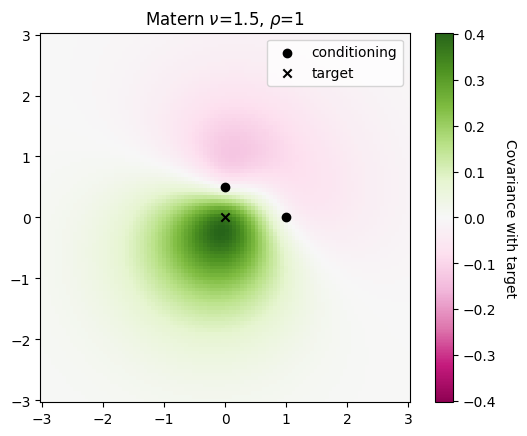

In [909]:
root_point = jnp.array([0.0, 0.0])
cond_points = jnp.array([[1.0, 0.0], [0.0, 0.5]])
grid_1d = jnp.linspace(-3, 3, 100)
grid_points = jnp.stack(jnp.meshgrid(grid_1d, grid_1d), axis=-1).reshape(-1, 2)
points = jnp.concatenate([root_point[None], cond_points, grid_points], axis=0)

p = 1
cutoff = 1
cov = gp.compute_cov_matrix(Partial(gp.compute_matern_covariance, p=p, cutoff=cutoff), points, points)
cond_cov = conditional_cov(cov, jnp.arange(1, len(cond_points)+1))[0]
grid_cov = cond_cov[1:]

im = plt.pcolormesh(grid_1d, grid_1d, grid_cov.reshape(len(grid_1d), len(grid_1d)), cmap='PiYG', vmin=-jnp.max(jnp.abs(grid_cov)), vmax=jnp.max(jnp.abs(grid_cov)))
plt.scatter(*cond_points.T, c='k', label='conditioning')
plt.scatter(*root_point.T, c='k', marker='x', label='target')
plt.gca().set(aspect='equal', title=fr"Matern $\nu$={p+1/2}, $\rho$={cutoff}")
cbar = plt.colorbar(im)
cbar.set_label('Covariance with target', rotation=270, labelpad=15)
plt.legend()
plt.show()

# Find optimal Markov blanket

In [845]:
import itertools

In [846]:
def variance_explained(cov, target_row, cond_rows):
    cond_cov = conditional_cov(cov, cond_rows, keep_size=True)
    return 1 - cond_cov[target_row, target_row] / cov[target_row, target_row]

In [869]:
N = 10
k = 4
combos = jnp.array(list(itertools.combinations(range(N), k)))
print(len(combos))

rng, k1 = jr.split(rng)
points = jr.normal(k1, (10, 2))
target = jnp.array([0.0, 0.0])

210


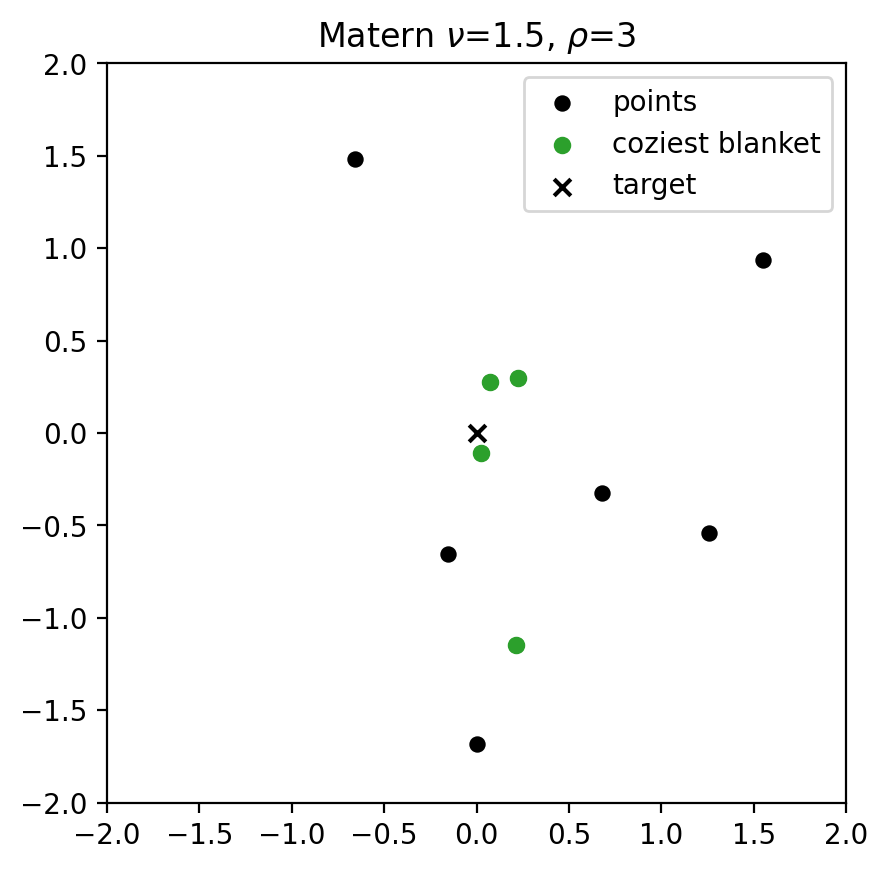

In [902]:
p = 1
cutoff = 3
cov_func = Partial(gp.compute_matern_covariance, p=p, cutoff=cutoff)
all_points = jnp.concatenate([target[None], points], axis=0)
cov = gp.compute_cov_matrix(cov_func, all_points, all_points)

score = jax.vmap(Partial(variance_explained, cov, 0))(combos + 1)
best = jnp.argmax(score)

plt.figure(dpi=200)
plt.scatter(*points.T, c='k', label='points', s=24)
plt.scatter(*points[combos[best]].T, c='C2', label='coziest blanket', s=28)
plt.scatter(*target, marker='x', c='k', label='target')
plt.gca().set(aspect='equal', xlim=(-2,2), ylim=(-2,2), title=fr"Matern $\nu$={p+1/2}, $\rho$={cutoff}")
plt.legend()
plt.show()

In [671]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, (4, 2))
covariance = gp.prepare_matern_covariance_discrete(p=0, cutoff=1, r_min=1e-5, r_max=10, n_bins=1000)
cov = gp.covariance.compute_cov_matrix(covariance, points, points)

In [679]:
cov[2]

Array([0.13842683, 0.53596693, 1.00001   , 0.22170559], dtype=float32)

In [681]:
conditional_cov(cov, [1], keep_size=True)[2]

Array([0.09776274, 0.        , 0.71275234, 0.01048008], dtype=float32)

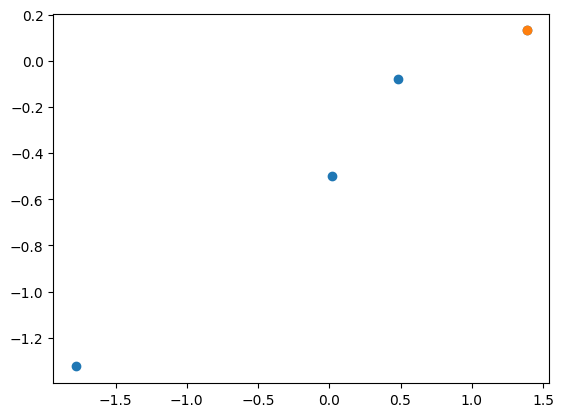

In [682]:
plt.scatter(*points.T)
plt.scatter(*points[3])

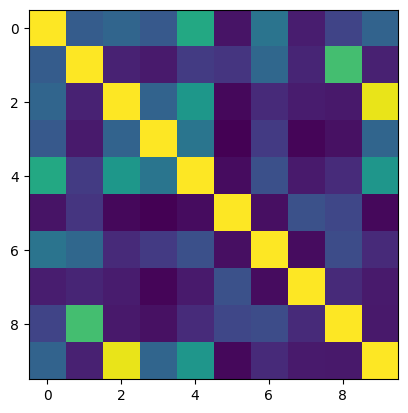

In [594]:
plt.imshow(cov)

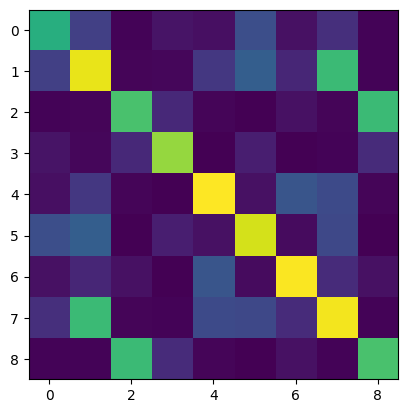

In [601]:
plt.imshow(conditional_cov(cov, jnp.array([4])))

5
4
6


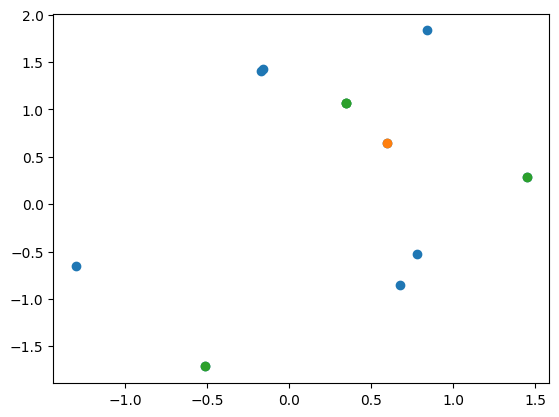

In [593]:
plt.scatter(*points.T)
plt.scatter(*points[0])

# Find most important single neighbors
neighbors = jnp.argsort(cov[0])[::-1][1:4]
# plt.scatter(*points[neighbors].T)

# Find most important neighbors iteratively
selected = jnp.array([neighbors[0]])
for i in range(3):
    cond_cov = conditional_cov(cov, jnp.array(selected))
    next_idx = jnp.argsort(cond_cov[0])[::-1][1]
    print(next_idx)
    selected = jnp.append(selected, next_idx)

plt.scatter(*points[selected].T)